In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from osgeo import ogr, osr

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib

import contextily as cx

import functions_bgt as func

In [2]:
# Load sidewalk BGT data
sidewalks_file = 'data/output/sidewalks_with_obstacles_all.gpkg'

# A CRS tells Python how those coordinates relate to places on the Earth. Rijksdriehoek = epsg:28992
CRS = 'epsg:28992'

# Read sidewalks data
df_sidewalks = gpd.read_file(sidewalks_file)
df_sidewalks = df_sidewalks.set_crs(CRS, allow_override=True)


In [3]:
df_sidewalks.head(12)

,ogc_fid,identificatie_lokaalid,naam,geometry
0,43811,G0363.f447cd24819f401fbd55596c08a8b662,voetpad,"POLYGON ((117983.438 486765.320, 117983.439 48..."
1,43821,G0363.f38b0fa5a20d4475b522bcf4abbaa643,voetpad,"POLYGON ((118036.867 486785.298, 118036.868 48..."
2,43822,G0363.dd8cfb0a0ef1486bb8555b980ba90c96,voetpad,"POLYGON ((118012.212 486795.300, 118012.213 48..."
3,43818,G0363.2f2cc4c6d8b64c52b884448d9f716a25,voetpad,"POLYGON ((117976.414 486792.709, 117976.415 48..."
4,43819,G0363.9b78408e7c39406084bd5576e8f95565,voetpad,"POLYGON ((117928.242 486839.000, 117928.242 48..."
5,44282,G0363.490a4927e9664962992324f7022dbba1,voetpad,"POLYGON ((118060.590 486974.144, 118060.591 48..."
6,44283,G0363.920d1d06e3f341c9bb282139734d5710,voetpad,"POLYGON ((118035.999 486982.818, 118036.000 48..."
7,44284,G0363.2a11e17391fd4e5c9a1a4958bded802c,voetpad,"POLYGON ((117979.791 486955.939, 117979.790 48..."
8,44285,G0363.ce53292ae04e4453ad6143677fceae6a,voetpad,"POLYGON ((118035.887 486987.190, 118035.888 48..."
9,44289,G0363.9dd661baa0a84e74ba7b3634ecc627e3,voetpad,"POLYGON ((118036.757 486953.121, 118036.758 48..."


<AxesSubplot: >

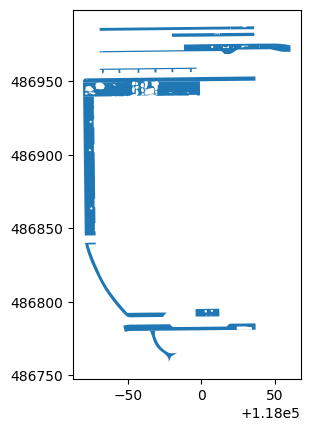

In [4]:
df_sidewalks.head(12).plot()

In [18]:
# Load panorama data
pano_file = '../dataset/centrum_west_small/panos.csv'

# read the CSV file
df = gpd.read_file(pano_file)
df.head()

,pano_id,heading,coords,geometry
0,TMX7316010203-002010_pano_0000_000266,71.4681283041747,"[4.90472584844721, 52.3888062757146, 46.497288...",None
1,TMX7316010203-002010_pano_0000_000267,65.0708600855714,"[4.90465159316434, 52.388792916203, 46.5166242...",None
2,TMX7316010203-002010_pano_0000_000268,64.2068499326293,"[4.90457955727434, 52.3887760419508, 46.557472...",None
3,TMX7316010203-002010_pano_0000_000269,68.4913649124737,"[4.90450521274369, 52.3887613422754, 46.573863...",None
4,TMX7316010203-002010_pano_0000_000270,70.12055068832,"[4.90442944296337, 52.3887491516695, 46.624173...",None


In [19]:
# extract the x, y, and z coordinates from the 'coords' column
df['x'] = df['coords'].apply(lambda x: x.split(',')[1])
df['y'] = df['coords'].apply(lambda x: x.split(',')[0].replace('[', ''))
df['z'] = df['coords'].apply(lambda x: x.split(',')[2].replace(']', ''))

# create a Point geometry column but don't trunk the coordinates
df['geometry'] = df.apply(lambda row: Point(float(row['y']), float(row['x']), float(row['z'])), axis=1)

# Transform df['x'] into a float maintaining the precision
#df['x'] = df['x'].astype(float)

# drop the 'coords', 'x', 'y' columns
df.drop(columns=['coords'], inplace=True)
df.drop(columns=['x'], inplace=True)
df.drop(columns=['y'], inplace=True)
df.drop(columns=['z'], inplace=True)

# Print head
df.head()

/home/andrealombardo/miniconda3/envs/sidewalk/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,pano_id,heading,geometry
0,TMX7316010203-002010_pano_0000_000266,71.4681283041747,POINT Z (4.90473 52.38881 46.49729)
1,TMX7316010203-002010_pano_0000_000267,65.0708600855714,POINT Z (4.90465 52.38879 46.51662)
2,TMX7316010203-002010_pano_0000_000268,64.2068499326293,POINT Z (4.90458 52.38878 46.55747)
3,TMX7316010203-002010_pano_0000_000269,68.4913649124737,POINT Z (4.90451 52.38876 46.57386)
4,TMX7316010203-002010_pano_0000_000270,70.12055068832,POINT Z (4.90443 52.38875 46.62417)


In [22]:
# Find the row with pano_id = TMX7316010203-002355_pano_0002_000268 and print it's geometry
print(df.loc[df['pano_id'] == 'TMX7316010203-002355_pano_0002_000268'])



                                     pano_id           heading  \
31880  TMX7316010203-002355_pano_0002_000268  154.921506598809   

                                  geometry  
31880  POINT Z (4.90373 52.37416 46.78158)  


In [20]:
# save the resulting GeoDataFrame to a new file
panos_path = 'panos.geojson'
df.to_file(panos_path, driver='GeoJSON')

In [21]:
# A CRS tells Python how those coordinates relate to places on the Earth. Rijksdriehoek = epsg:28992
panos_CRS = 'epsg:4326'

# Read sidewalks data
df_panos = gpd.read_file(panos_path)
print(df_panos.crs)

None


In [9]:
#df_panos = df_panos.set_crs(panos_CRS, allow_override=True)


epsg:28992


<AxesSubplot: >

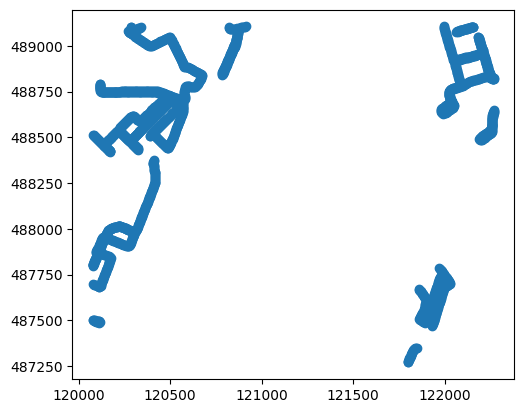

In [10]:
# Convert to RD
df_panos = df_panos.to_crs(CRS)
print(df_panos.crs)
# Plot head
df_panos.head(2000).plot()

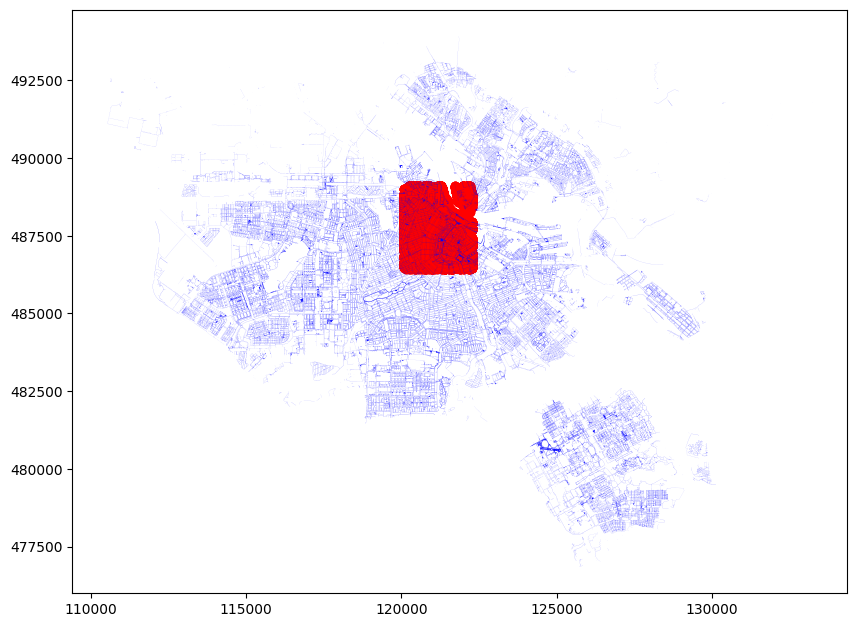

In [11]:
# Plot df_panos and df_sidewalks
fig, ax = plt.subplots(figsize=(10,10))
df_panos.plot(ax=ax, color='red')
df_sidewalks.plot(ax=ax, color='blue')
plt.show()

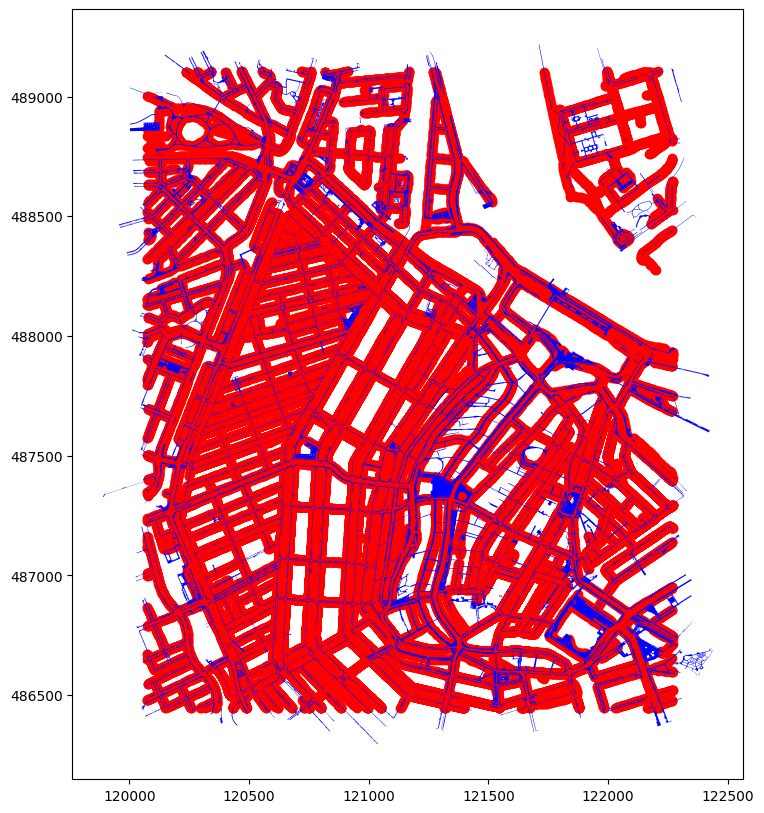

In [12]:
# Get boundaries of df_panos
minx, miny, maxx, maxy = df_panos.total_bounds

# Limit df_sidewalks to the boundaries of df_panos
df_sidewalks = df_sidewalks.cx[minx:maxx, miny:maxy]

# Plot df_panos and df_sidewalks
fig, ax = plt.subplots(figsize=(10,10))
df_panos.plot(ax=ax, color='red')
df_sidewalks.plot(ax=ax, color='blue')
plt.show()

TMX7316010203-002355_pano_0002_000268


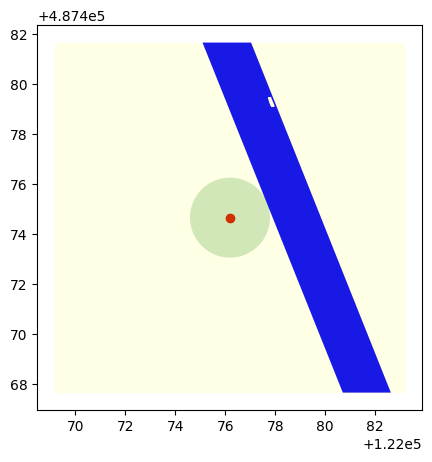

In [13]:

# Select pano with pano_id = TMX7316010203-002355_pano_0002_000268
pano = df_panos.iloc[31880]

print(pano['pano_id'])
buffer = pano.geometry.buffer(1.6)
fig, ax = plt.subplots(figsize=(5,5))

# Create a new GeoDataFrame with a single row containing the pano geometry
gdf_pano = gpd.GeoDataFrame(geometry=[pano.geometry])

# Plot the GeoDataFrame with the pano geometry
gdf_pano.plot(ax=ax, color='red')

# Plot the buffer around the pano geometry
gdf_buffer = gpd.GeoDataFrame(geometry=[buffer])
gdf_buffer.plot(ax=ax, color='green', alpha=0.2)

# Create a rectangle around the pano geometry
rect = pano.geometry.buffer(7).envelope

# Cut the sidewalk polygons with the rectangle
df_sidewalks_cut = df_sidewalks[df_sidewalks.intersects(rect)]

# Take only the portion of the polygon that is inside the rectangle
df_sidewalks_cut = df_sidewalks_cut.intersection(rect)

# Take only the first polygon and turn it into a GeoDataFrame
df_sidewalks_cut_1 = gpd.GeoDataFrame(geometry=[df_sidewalks_cut.iloc[1]])

df_sidewalks_cut_1.plot(ax=ax, color='blue')

# Plot it
gdf_rect = gpd.GeoDataFrame(geometry=[rect])
gdf_rect.plot(ax=ax, color='yellow', alpha=0.1)

plt.show()

To calculate the focal length in pixels, we can use the following formula:

focal length in pixels = (focal length in mm * sensor resolution) / (sensor size in mm * pixel size)

Where:

Focal length in mm = 4.4 mm
Sensor resolution = 2048 x 2448 pixels
Sensor size = 8.8 mm x 6.6 mm
Pixel size = 3.45 μm

To use this formula, we need to convert the focal length from millimeters to micrometers. One millimeter is equal to 1000 micrometers, so 4.4 mm is equal to 4400 μm.

Plugging these values into the formula, we get:

focal length in pixels = (4400 * 2048) / (8.8 * 1000 * 3.45)

focal length in pixels = 296.81 pixels

Therefore, the focal length in pixels for the Sony ICX655 sensor with a focal length of 4.4 mm is approximately 296.81 pixels.

In [31]:
import cv2
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from functools import partial
import pyproj
import math

# Load the panoramic image and extract its dimensions
#pano_img = cv2.imread('../dataset/centrum_west_small/reoriented/TMX7316010203-002355_pano_0002_000268')
pano_img = cv2.imread('../dataset/centrum_west_small/reprojected/TMX7316010203-002355_pano_0002_000268/right.png')
pano_height, pano_width, _ = pano_img.shape
print(pano_height, pano_width)

# Define the camera matrix and distortion coefficients
fx = 296.81 # horizontal focal length in pixels
fy = 296.81 # vertical focal length in pixels
cx = pano_width / 2 # x-coordinate of principal point
cy = pano_height / 2 # y-coordinate of principal point
K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]]) # intrinsic matrix
R = np.eye(3)  # rotation matrix
t = np.array([0, 0, 2])  # translation vector (height of camera is 2 meters)
#dist_coeffs = np.zeros((4, 1)) # assuming no lens distortion

# Define Shapely polygon representing the sidewalk
sidewalk_polygon = df_sidewalks_cut_1

# Assumption: sidewalk_height is the height of the panorama camera above the ground + 0.02 meters

# Extrude the Shapely polygon by the sidewalk height to create a 3D polygon
sidewalk_height = 46.78158 + 0.02  # height of sidewalk in meters (epsg:4326)
#sidewalk_3d = sg.MultiPolygon([sidewalk_polygon.extrude(height=sidewalk_height)])

# Transform the 3D coordinates of the sidewalk polygon to EPSG:4326
transformer = pyproj.Transformer.from_crs('epsg:28992', 'epsg:4326', always_xy=True)

# Concatenate 3D coordinates of all sidewalk polygon exterior rings
corners_3d = np.empty((0, 3))
for i, polygon in df_sidewalks_cut_1['geometry'].iteritems():
    coords_3d = np.array([list(transformer.transform(coords[0], coords[1])) + [sidewalk_height] for coords in polygon.exterior.coords])
    corners_3d = np.vstack([corners_3d, coords_3d])

# Convert 3D coordinates of sidewalk corners to homogeneous coordinates
corners_3d_homogeneous = np.hstack((corners_3d, np.ones((corners_3d.shape[0], 1))))

512 512


/tmp/ipykernel_11194/140823138.py:39: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, polygon in df_sidewalks_cut_1['geometry'].iteritems():


From the Puccini Method, we assume that the width of the sidewalk is between 10cm and 30cm. We take the average of the values, which is 20cm. Às a first approximation, we can assume the sidewalk height is 2cm.

In [32]:
# Compute camera matrix P = K[R|t]
P = np.dot(K, np.hstack((R, t.reshape((3, 1)))))

# Compute 2D image coordinates of sidewalk corners in the camera coordinate system
corners_2d_homogeneous = np.dot(P, corners_3d_homogeneous.T)
corners_2d = corners_2d_homogeneous[:2, :] / corners_2d_homogeneous[2, :]
print(corners_2d)

[[285.82446702 285.8249177  285.824746   285.82423651 285.82441004
  285.82446702]
 [574.53862703 574.53794949 574.53794879 574.53871199 574.5387127
  574.53862703]]


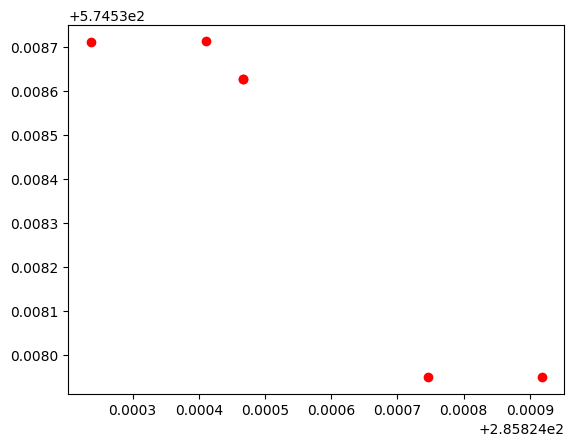

In [33]:
# Visualize corners_2d
fig, ax = plt.subplots()
#ax.imshow(pano_img)
ax.scatter(corners_2d[0, :], corners_2d[1, :], color='red')
plt.show()